In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import io
import lmdb
import zipfile
import tarfile


def open_and_measure_data(
    data_path, archive_type, threshold=-1
):
    heights = []
    widths = []
    num_images = 0
    folder_name = ""
    if archive_type == 'lmdb':

        folder_name = data_path.split('/')[-1]

        env_imgs = lmdb.open(data_path, readonly=True)

        with env_imgs.begin() as txn_imgs:
            cursor_imgs = txn_imgs.cursor()
        #  cursor_labels = txn_labels.cursor()
            for (img_key, img_value) in cursor_imgs:
                img = Image.open(io.BytesIO(img_value))
                width, height = img.size
                # print('Image format = ', img.size)
                
                num_images += 1
                if width < 400 and height < 400:
                    widths.append(width)
                    heights.append(height)

                num_images += 1
                if width < 400 and height < 400:
                    widths.append(width)
                    heights.append(height)

    elif archive_type == "zip":
        folder_name = os.path.basename(data_path)
        with zipfile.ZipFile(data_path, "r") as zip_file:
            image_files = [
                name
                for name in zip_file.namelist()
                if name.lower().endswith(
                    (".png", ".jpg", ".jpeg")
                )
            ]
            for img_file in image_files:
                with zip_file.open(img_file) as img_data:
                    img = Image.open(img_data)
                    width, height = img.size
                    num_images += 1
                    if width < 400 and height < 400:
                        widths.append(width)
                        heights.append(height)
                        widths.append(width)

    elif archive_type == "tar":
        folder_name = os.path.basename(data_path)
        with tarfile.open(data_path, "r") as tar_file:
            image_files = [
                member
                for member in tar_file.getmembers()
                if member.name.lower().endswith(
                    (".png", ".jpg", ".jpeg")
                )
            ]
            for img_file in image_files:
                img_data = tar_file.extractfile(img_file)
                if img_data:
                    img = Image.open(img_data)
                    width, height = img.size
                    num_images += 1
                    if width < 400 and height < 400:
                        widths.append(width)
                        heights.append(height)
    else:
        raise ValueError("Unsupported archive type. Use 'zip' or 'tar'.")
    
             

    height_stats = {
        "median": np.median(heights),
        "mean": np.mean(heights),
        "std": np.std(heights),
        "min": np.amin(heights),
        "max": np.amax(heights),
    }

    width_stats = {
            'median': np.median(widths),
            'mean': np.mean(widths),
            'std': np.std(widths),
            'min': np.min(widths),
            'max': np.max(widths)
        }
    
    plt.hist2d(widths, heights, bins=100)
    plt.colorbar()
    plt.xlabel("Width (in px)")
    plt.ylabel("Height (in px)")
    plt.title(
        f"{folder_name} Size Distribution (Log Scale) ({len(heights)} images)"
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return height_stats, width_stats




## Pisco


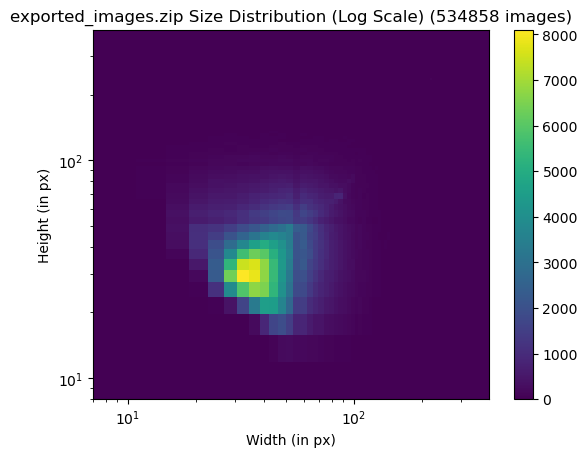

({'median': 41.0,
  'mean': 47.920974705237825,
  'std': 27.585914114324705,
  'min': 8,
  'max': 399},
 {'median': 47.0,
  'mean': 52.90884707953662,
  'std': 26.73974251774121,
  'min': 7,
  'max': 399})

In [9]:
data_dir_pisco = '/home/hk-project-p0021769/hgf_vwg6996/data/pisco_zip/exported_images.zip'
open_and_measure_data(data_dir_pisco, 'zip')

In [7]:
data_dir = '/home/hk-project-p0021769/hgf_col5747/data/datasciencebowl/datasciencebowl.zip'
open_and_measure_data(data_dir_pisco, 'zip')

BadZipFile: File is not a zip file

In [4]:
data_dir_lmdb = "/home/hk-project-p0021769/hgf_col5747/data/whoi_lmdb-TRAIN_imgs"
# open_and_measure_data(data_dir_lmdb)

In [5]:
data_dir_lmdb = "/home/hk-project-p0021769/hgf_col5747/data/plankton/-TRAIN_imgs"
# open_and_measure_lmdb_file(data_dir_lmdb)

In [6]:
data_dir_lmdb = "/home/hk-project-p0021769/hgf_col5747/data/plankton/-VAL_imgs"
# open_and_measure_lmdb_file(data_dir_lmdb)

In [ ]:
def count_entries(lmdb_path):
    env = lmdb.open(lmdb_path, readonly=True)
    
    with env.begin() as txn:
        cursor = txn.cursor()
        count = 0
        for key, _ in cursor:
            count += 1
        
    env.close()
    return count

def load_and_verify_lmdb(lmdb_imgs_path, lmdb_labels_path, debug_output_dir, max_images=10):
    num_images = count_entries(lmdb_imgs_path)
    num_labels = count_entries(lmdb_labels_path)
    
    print(f"Number of images in LMDB: {num_images}")
    print(f"Number of labels in LMDB: {num_labels}")

    env_imgs = lmdb.open(lmdb_imgs_path, readonly=True)
    env_labels = lmdb.open(lmdb_labels_path, readonly=True)

    with env_imgs.begin() as txn_imgs, env_labels.begin() as txn_labels:
        cursor_imgs = txn_imgs.cursor()
        cursor_labels = txn_labels.cursor()        
        count = 0
        for (img_key, img_value), (label_key, label_value) in zip(cursor_imgs, cursor_labels):
            img_decoded = iio.imread(img_value)
            
            label_decoded = label_value.decode("utf-8")
            
            # Save the image for verification
            output_path = os.path.join(debug_output_dir, f"debug_{label_decoded}_{count}.png")
            iio.imwrite(output_path, img_decoded)
            
            print(f"Verified Image Key: {img_key.decode('utf-8')}, Label: {label_decoded}, Saved to: {output_path}")
            
            count += 1
            if count >= max_images:  # dont want to save all images
                break

    env_imgs.close()
    env_labels.close()
    print(f"Verification complete. Images saved to {debug_output_dir}")